# Fig9. Relative weight of each department in the nine main research centres. To favour comparison, each group of values is stacked at 100%. 

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import matplotlib as mpl


plt.style.use('seaborn-muted')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def read_csv(path):
    """
    :param path: of desir the xlsx file
    :return: String that contains all project descriptions
    """
    df = pd.read_csv(path)
    filtered_df = df.fillna(0)
    
    
    return filtered_df

#### Define projects data path

In [2]:
file_path = "data/mapeo_investigadores.csv"

#### Define function to clean data

In [3]:
def translate(dataframe, column_to_translate, translations_filename):    
    translations_df = pd.read_csv(f"data/{translations_filename}")
    translations_df.columns=["organismo", "acronimo"]
    translations_df['organismo'] = translations_df['organismo'].str.upper()
    translations_df['organismo'] = translations_df['organismo'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    dataframe[column_to_translate] = dataframe[column_to_translate].str.upper()
    dataframe[column_to_translate] = dataframe[column_to_translate].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_def = pd.merge(dataframe, translations_df, on=column_to_translate, how='inner')
    return df_def

In [4]:
def prepare_data(data, num_of_centres):
    data.drop_duplicates(subset ="ID investigador", keep = "first", inplace = True)
    data = data.loc[data["Universidad"] != 0]
    data = data.loc[data["Departamento / Centro"] != 0]
    mini2 = data.loc[:, ("ID investigador", "Universidad", "Departamento / Centro", "Área de procedencia/disciplina")]
    mini2.columns = ["id", "uni", "dpto", "disciplina"]
    mini2.loc[mini2["uni"]=="Agencia Estatal Consejo Superior de Investigaciones Científicas (CSIC)", "dpto"] = mini2.loc[mini2["uni"]=="Agencia Estatal Consejo Superior de Investigaciones Científicas (CSIC)", "disciplina"]
    mini = mini2.drop(columns=['disciplina'])
    
    filtered_df = mini.loc[mini["dpto"].str.contains('\|')]
    mini = mini.loc[mini["dpto"].str.contains('\|') != True]
    new_discp = []
    for row in filtered_df.itertuples():
        for disciplina in row.dpto.split(" | "):
            new_discp.append([row.id, row.uni, disciplina])
    fix_df = pd.DataFrame(new_discp, columns=["id", "uni", "dpto"])
    mini = mini.append(fix_df)
    
    # manual fixes
    mini.loc[mini["dpto"].str.upper().str.contains('BIBLIOTECA'), "dpto"] = "Biblioteconomía y documentación"
    mini.loc[mini["dpto"].str.upper() == "PREHISTORIA Y ARQUEOLOGÍA", "dpto"] = "Arqueología"
    mini.loc[mini["dpto"].str.upper() == "EDUCACIÓN", "dpto"] = "Ciencias de la educación"
    mini.loc[mini["dpto"].str.upper() == "HUMANIDADES", "dpto"] = "Historia"
    mini.loc[mini["dpto"].str.upper().isin(["INFORMÁTICA Y ANÁLISIS NUMÉRICO", "LENGUAJES Y SISTEMAS INFORMÁTICOS"]), "dpto"] = "Ciencias de la computación"
    mini.loc[mini["dpto"].str.upper().isin(["CIENCIAS Y TÉCNICAS HISTORIOGRÁFICAS", "INSTITUTO DE HISTORIOGRAFÍA JULIO CARO BAROJA"]), "dpto"] = "Historia"
    # mini.loc[mini["dpto"].str.upper() == "LENGUAJES Y SISTEMAS INFORMÁTICOS", "dpto"] = "Historia"
    
    mini.loc[:, "dpto"] = mini["dpto"].str.upper()    
    translations_df = pd.read_csv(f"data/disciplinas.csv")
    translations_df.columns=["dpto", "translation"]
    translations_df.loc[:, "dpto"] = translations_df['dpto'].str.upper()
    translations_df.loc[:, "dpto"] = translations_df['dpto'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    mini.loc[:, "dpto"] = mini["dpto"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_def = pd.merge(mini, translations_df, on="dpto", how='outer')
    df_def.loc[pd.isnull(df_def.translation), "translation"] = "Others"
    
    uni_df = mini.groupby("uni").agg({'id': 'count'})
    uni_list = uni_df.nlargest(num_of_centres, "id").index.tolist()
    grp = df_def.groupby(['uni', 'translation']).agg({'id': 'count'})
    grp_pcts = grp.groupby(level=0).apply(lambda x: x / float(x.sum())).sort_values(['id'], ascending=False)
    # display(grp_pcts.loc[grp_pcts["organismo"].str.contains('UNIVERSIDAD COMPLUTENSE')])
    # df_def = translate(grp_pcts, "organismo", "universidades.csv")
    # result_df = grp_pcts.loc[grp_pcts["uni"].isin(uni_list)]
    result = grp_pcts[grp_pcts.index.isin(uni_list, level="uni")]
    result = result.reindex(uni_list, level="uni")
    unstacked = result.unstack()
    return unstacked# .sort_values(by='id', ascending=False)

#### Run program
## Change 'num_of_centres' to show as many centres as you want'

In [5]:
num_of_centres = 9
proyectos = read_csv(file_path)
df2 = prepare_data(proyectos, num_of_centres)

#### Print graph

<Figure size 432x288 with 0 Axes>

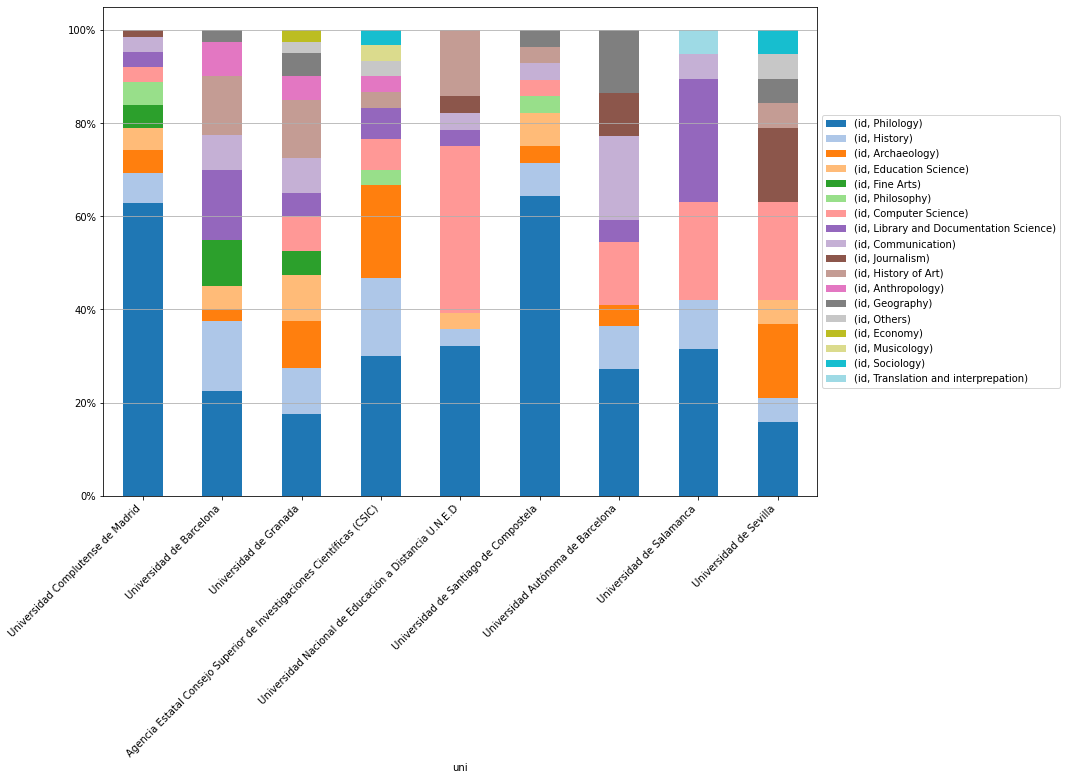

In [6]:
plt.figure()
# colors =  plt.cm.get_cmap("tab20")( (4./3*np.arange(20*3/4)).astype(int) )
ax1 = df2.plot(stacked=True, kind="bar", figsize=(16,9), colormap="tab20")
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=0))
plt.grid(axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [7]:
df2

id            \
translation                                        Philology   History   
uni                                                                      
Universidad Complutense de Madrid                   0.629032  0.064516   
Universidad de Barcelona                            0.225000  0.150000   
Universidad de Granada                              0.175000  0.100000   
Agencia Estatal Consejo Superior de Investigaci...  0.300000  0.166667   
Universidad Nacional de Educación a Distancia U...  0.321429  0.035714   
Universidad de Santiago de Compostela               0.642857  0.071429   
Universidad Autónoma de Barcelona                   0.272727  0.090909   
Universidad de Salamanca                            0.315789  0.105263   
Universidad de Sevilla                              0.157895  0.052632   

                                                                \
translation                                        Archaeology   
uni                                                              
Universidad Complutense de Madrid                     0.048387   
Universidad de Barcelona                              0.025000   
Universidad de Granada                                0.100000   
Agencia Estatal Consejo Superior de Investigaci...    0.200000   
Universidad Nacional de Educación a Distancia U...         NaN   
Universidad de Santiago de Compostela                 0.035714   
Universidad Autónoma de Barcelona                     0.045455   
Universidad de Salamanca                                   NaN   
Universidad de Sevilla                                0.157895   

                                                                      \
translation                                        Education Science   
uni                                                                    
Universidad Complutense de Madrid                           0.048387   
Universidad de Barcelona                                    0.050000   
Universidad de Granada                                      0.100000   
Agencia Estatal Consejo Superior de Investigaci...               NaN   
Universidad Nacional de Educación a Distancia U...          0.035714   
Universidad de Santiago de Compostela                       0.071429   
Universidad Autónoma de Barcelona                                NaN   
Universidad de Salamanca                                         NaN   
Universidad de Sevilla                                      0.052632   

                                                                         \
translation                                        Fine Arts Philosophy   
uni                                                                       
Universidad Complutense de Madrid                   0.048387   0.048387   
Universidad de Barcelona                            0.100000        NaN   
Universidad de Granada                              0.050000        NaN   
Agencia Estatal Consejo Superior de Investigaci...       NaN   0.033333   
Universidad Nacional de Educación a Distancia U...       NaN        NaN   
Universidad de Santiago de Compostela                    NaN   0.035714   
Universidad Autónoma de Barcelona                        NaN        NaN   
Universidad de Salamanca                                 NaN        NaN   
Universidad de Sevilla                                   NaN        NaN   

                                                                     \
translation                                        Computer Science   
uni                                                                   
Universidad Complutense de Madrid                          0.032258   
Universidad de Barcelona                                        NaN   
Universidad de Granada                                     0.075000   
Agencia Estatal Consejo Superior de Investigaci...         0.066667   
Universidad Nacional de Educación a Distancia U...         0.357143   
Universidad de Santiago de Compostela     